# Solves the single-species two-dimensional adhesion equation on a rectangular lattice and computes the psuedo-1D average of the 2D solution.
### Solving the single-species adhesion equation in 2d using py-pde package. Refer to the documentation at: https://py-pde.readthedocs.io/en/latest/index.html


In [110]:
#import modules
import numpy as np
from numpy import log
#import modules from the py-pde package
from pde import PDE, CartesianGrid, ScalarField, DiffusionPDE, FieldCollection, PDEBase, UnitGrid
import pde
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import io
from scipy import integrate


### Initialise the domain, discretisation, initial and boundary conditions

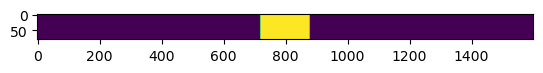

In [257]:
L_x=400 #domain length -- x-axis
L_y=20 #domain width -- y-axis
dx=0.25
dy=0.25
npts_x=np.int64(L_x/dx) #cols
npts_y=np.int64(L_y/dy) #rows
q=0 #adhesion strength
T_final=1000
D=0.25 #diffusion coefficient

grid = CartesianGrid([[0, L_y], [0, L_x]], [npts_y, npts_x])

bc_x = {"derivative": 0}
bc_y = {"derivative": 0}


state = ScalarField(grid)  # generate initial condition
state.data[:,int(0.45*npts_x):int(0.55*npts_x)]=1

#visualise the init cond
plt.imshow(state.data)

In [260]:
np.sum(state.data[0,:])/npts_x

0.1

### Define the PDE

In [261]:
eq = PDE({"C": f"{D}*divergence((1-{q})**(4*C)*(1-4*C*(C-1)*log(1-{q}))*gradient(C))"},bc=[bc_x,bc_y])

#this line ensure all your solutions (in time) are stored and not just the one at the last time point
storage = pde.MemoryStorage()

### Solve the PDE

In [262]:
result = eq.solve(state, t_range=T_final,dt=1e-2, adaptive="True", tracker=["progress", storage.tracker(100)])


  0%|          | 0/1000.0 [00:00<?, ?it/s]

In [263]:
 #extract pde solution at t=0,100 and 1000
sol_t0=list(storage.items())[0][1].data
sol_t100=list(storage.items())[1][1].data
sol_t1000=list(storage.items())[10][1].data

In [264]:
len(list(storage.items()))

11

### Compute the psuedo-1D solution using trapezium rule to do the integration

In [265]:
x = np.linspace(0, L_x, npts_x)
y = np.linspace(0, L_y,npts_y)

sol_t0_1D=integrate.trapezoid(sol_t0,y,axis=0)/L_y

sol_t100_1D=integrate.trapezoid(sol_t100,y,axis=0)/L_y

sol_t1000_1D=integrate.trapezoid(sol_t1000,y,axis=0)/L_y

### Plot psuedo-1D solution

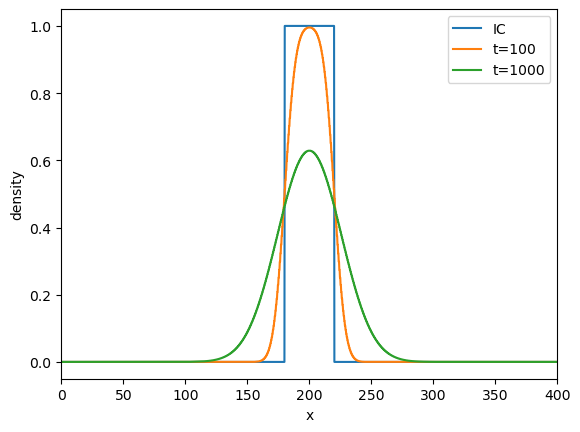

In [266]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x,sol_t0_1D,label='IC')
ax.plot(x,sol_t100_1D,label='t=100')
ax.plot(x,sol_t1000_1D,label='t=1000')

ax.set_xlim([0,400])
plt.xlabel('x');
plt.ylabel('density')
plt.legend()
plt.show()

In [267]:
### Plot the 2D solution

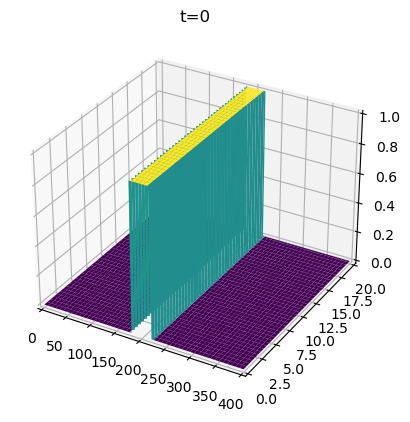

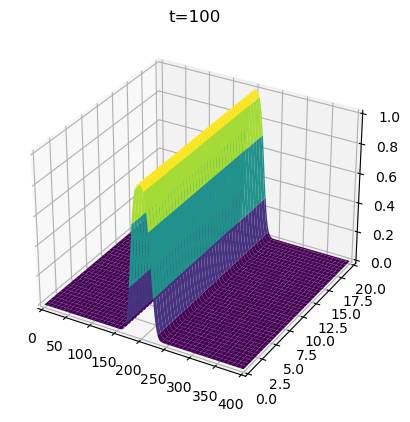

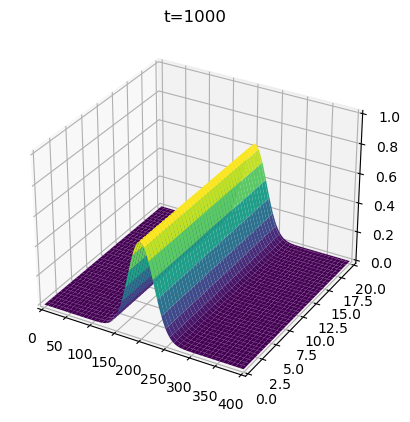

In [268]:
X, Y = np.meshgrid(x, y)

fig = plt.figure(1)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, sol_t0, cmap='viridis')
ax.set_xlim([0,L_x])
ax.set_ylim([0,L_y])
ax.set_zlim([0,1])
plt.title('t=0')

fig = plt.figure(2)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, sol_t100, cmap='viridis')
ax.set_xlim([0,L_x])
ax.set_ylim([0,L_y])
ax.set_zlim([0,1])
plt.title('t=100')

fig = plt.figure(3)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, sol_t1000, cmap='viridis')
ax.set_xlim([0,L_x])
ax.set_ylim([0,L_y])
ax.set_zlim([0,1])
plt.title('t=1000')

plt.show()

In [269]:
#save to .mat format

dx=x[1]-x[0]
dy=y[1]-y[0]



sol_1D=np.empty((3,npts_x)) #(3 time points, npts_x grid pioitns)


sol_1D[0,:]=sol_t0_1D
sol_1D[1,:]=sol_t100_1D
sol_1D[2,:]=sol_t1000_1D


data_dict={"sol_1D": sol_1D, "x": x, "y": y, "dx": dx, "dy": dy, "q" : q, "L_x":L_x, "L_y":L_y, "n_pde_pts_x":npts_x, "n_pde_pts_y":npts_y, "T_final":T_final, "D":D}
io.savemat('ts_2d_pde_data_q_'+str(q)+'_T_'+str(T_final)+'.mat',data_dict)


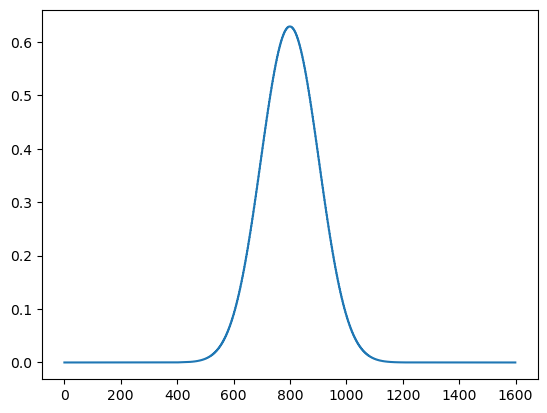

In [270]:
plt.plot(sol_1D[2,:])
plt.show()